导包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import random

获取主数据集
test_data 为不可见数据集

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
ia.seed(seed_value)

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

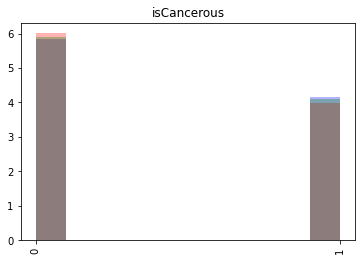

In [159]:
plt.hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['isCancerous'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['isCancerous'], alpha=0.3, color='g', label='Val',  density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '2'), Text(3, 0, '3')])

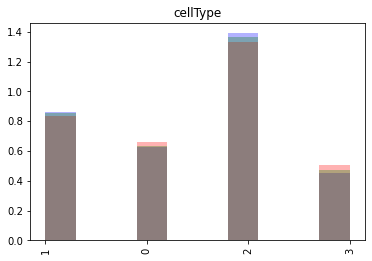

In [160]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [3]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [4]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

In [5]:
batch_size = 32
train_datagen = CustomImageDataGenerator(
    num_augmentations=3,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [6]:
train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [7]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiCategoryF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_category=4, average='macro', name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_category
        self.average = average
        self.confusion_matrix = self.add_weight(name="confusion_matrix", shape=(num_classes, num_classes), initializer="zeros", dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        current_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        self.confusion_matrix.assign_add(current_confusion_matrix)


    def result(self):
        confusion_matrix = self.total_confusion_matrix
        tp = tf.linalg.diag_part(confusion_matrix)
        fp = tf.reduce_sum(confusion_matrix, axis=0) - tp
        fn = tf.reduce_sum(confusion_matrix, axis=1) - tp

        precision_per_class = tp / (tp + fp)
        recall_per_class = tp / (tp + fn)

        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")

        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes, "average": self.average})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [8]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01
baseline_binary = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Pro


In [167]:
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
baseline_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                              tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'),
                              F1Score()])

baseline_categorical.compile(loss='categorical_crossentropy',
                             optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                             metrics=['accuracy',
                                      tf.keras.metrics.Precision(name='precision'),
                                      tf.keras.metrics.Recall(name='recall'),
                                      MultiCategoryF1Score(num_category=4)])

NameError: name 'baseline_categorical' is not defined

In [169]:
epochs = 100
baseline_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
)

Epoch 1/100
197/197 [==============================] - 4s 17ms/step - loss: 1.1347 - accuracy: 0.7189 - precision: 0.6511 - recall: 0.7033 - f1_score: 0.6762 - val_loss: 0.4557 - val_accuracy: 0.7889 - val_precision: 0.6760 - val_recall: 0.9332 - val_f1_score: 0.7841
Epoch 2/100
197/197 [==============================] - 3s 14ms/step - loss: 0.8647 - accuracy: 0.8127 - precision: 0.7513 - recall: 0.8223 - f1_score: 0.7852 - val_loss: 0.3487 - val_accuracy: 0.8527 - val_precision: 0.8627 - val_recall: 0.7621 - val_f1_score: 0.8092
Epoch 3/100
197/197 [==============================] - 3s 14ms/step - loss: 0.8815 - accuracy: 0.8010 - precision: 0.7353 - recall: 0.8170 - f1_score: 0.7740 - val_loss: 0.3470 - val_accuracy: 0.8457 - val_precision: 0.8667 - val_recall: 0.7335 - val_f1_score: 0.7946
Epoch 4/100
197/197 [==============================] - 3s 13ms/step - loss: 0.8251 - accuracy: 0.8202 - precision: 0.7518 - recall: 0.8483 - f1_score: 0.7971 - val_loss: 0.5132 - val_accuracy: 0.7

In [24]:
baseline_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 1s 9ms/step - loss: 0.7133 - accuracy: 0.3869 - precision: 0.3339 - recall: 0.5373 - f1_score: 0.4118


[0.7132663726806641,
 0.3868686854839325,
 0.3338570296764374,
 0.5372945666313171,
 0.4118216633796692]

In [171]:
epochs = 100
baseline_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
)

Epoch 1/100
196/197 [============================>.] - ETA: 0s - loss: 5.4951 - accuracy: 0.3821 - precision: 0.5519 - recall: 0.0593 - f1_score: 0.3429

/Users/hueybai/miniconda3/envs/DL/lib/python3.10/site-packages/keras/engine/training.py:2448: UserWarning: Metric MultiCategoryF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


197/197 [==============================] - 5s 22ms/step - loss: 5.4910 - accuracy: 0.3817 - precision: 0.5519 - recall: 0.0590 - f1_score: 0.3428 - val_loss: 1.0731 - val_accuracy: 0.5389 - val_precision: 0.9053 - val_recall: 0.2073 - val_f1_score: 0.5241
Epoch 2/100
197/197 [==============================] - 4s 19ms/step - loss: 4.8049 - accuracy: 0.5271 - precision: 0.7911 - recall: 0.2206 - f1_score: 0.4491 - val_loss: 0.9488 - val_accuracy: 0.6365 - val_precision: 0.8762 - val_recall: 0.2800 - val_f1_score: 0.5807
Epoch 3/100
197/197 [==============================] - 4s 19ms/step - loss: 4.6116 - accuracy: 0.5551 - precision: 0.7447 - recall: 0.2763 - f1_score: 0.4774 - val_loss: 1.2706 - val_accuracy: 0.4974 - val_precision: 0.7358 - val_recall: 0.2487 - val_f1_score: 0.4921
Epoch 4/100
197/197 [==============================] - 4s 19ms/step - loss: 4.4493 - accuracy: 0.5863 - precision: 0.7553 - recall: 0.3287 - f1_score: 0.5087 - val_loss: 0.8866 - val_accuracy: 0.6690 - val_pr

In [172]:
baseline_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 1s 15ms/step - loss: 0.7535 - accuracy: 0.7152 - precision: 0.8066 - recall: 0.5833 - f1_score: 0.6683


[0.7534627914428711,
 0.7151514887809753,
 0.8065642714500427,
 0.5833333134651184,
 0.6682605147361755]

两层卷积一层池化，32，64。两层512感知器。

In [9]:
model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                      

In [10]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [11]:
model_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       F1Score()])

model_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   F1Score()])

In [12]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)

In [12]:
epochs = 100
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

NameError: name 'epochs' is not defined

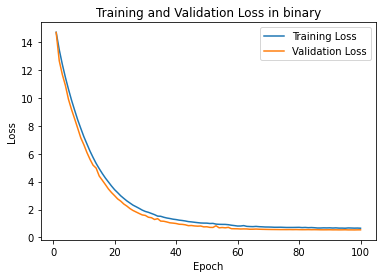

In [178]:
train_loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

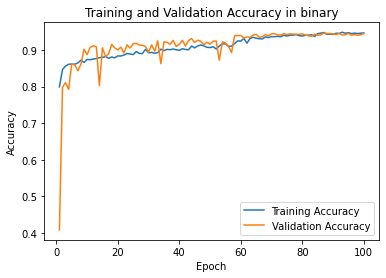

In [179]:
train_accuracy = history_binary.history['accuracy']
val_accuracy = history_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

评估不可见数据集的表现

In [180]:
model_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 2s 30ms/step - loss: 0.5743 - accuracy: 0.9323 - precision: 0.9001 - recall: 0.9343 - f1_score: 0.9169


[0.5742926597595215,
 0.9323232173919678,
 0.900121808052063,
 0.9342604279518127,
 0.9168733358383179]

# 训练多分类

In [70]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 11s 51ms/step - loss: 19.2475 - accuracy: 0.5597 - precision: 0.6010 - recall: 0.5011 - f1_score: 0.5465 - val_loss: 15.5416 - val_accuracy: 0.2870 - val_precision: 0.2860 - val_recall: 0.2812 - val_f1_score: 0.2836 - lr: 5.0000e-04
Epoch 2/100
197/197 [==============================] - 9s 45ms/step - loss: 16.9749 - accuracy: 0.6035 - precision: 0.6572 - recall: 0.5340 - f1_score: 0.5892 - val_loss: 13.2214 - val_accuracy: 0.5383 - val_precision: 0.5739 - val_recall: 0.5128 - val_f1_score: 0.5416 - lr: 5.0000e-04
Epoch 3/100
197/197 [==============================] - 9s 46ms/step - loss: 15.2587 - accuracy: 0.6302 - precision: 0.6860 - recall: 0.5527 - f1_score: 0.6122 - val_loss: 11.2268 - val_accuracy: 0.7136 - val_precision: 0.7950 - val_recall: 0.6135 - val_f1_score: 0.6926 - lr: 5.0000e-04
Epoch 4/100
197/197 [==============================] - 9s 48ms/step - loss: 13.5708 - accuracy: 0.6467 - precision: 0.7153 - recall: 0.571

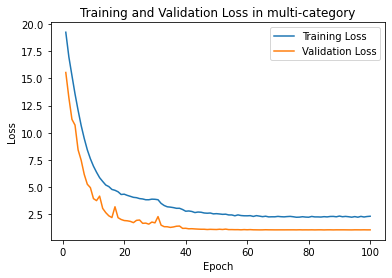

In [71]:
train_loss = history_categorical.history['loss']
val_loss = history_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

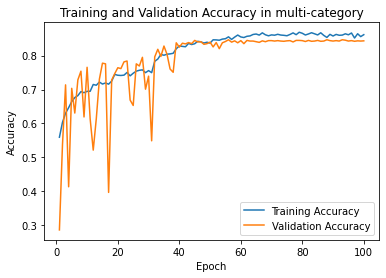

In [72]:
train_accuracy = history_categorical.history['accuracy']
val_accuracy = history_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [14]:
model_categorical.evaluate(test_cellType_generator)
# loss: 1.1398 - accuracy: 0.8338 - precision: 0.8502 - recall: 0.8172 - f1_score: 0.8334

2023-05-05 18:14:58.463602: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


62/62 [==============================] - 2s 26ms/step - loss: 1.1468 - accuracy: 0.8323 - precision: 0.8496 - recall: 0.8162 - f1_score: 0.8326


[1.1467695236206055,
 0.8323232531547546,
 0.8496319651603699,
 0.8161616325378418,
 0.8325604796409607]

In [48]:
model_categorical.save_weights('saved_model/model_categorical_weights')

# DI/HD 使用data_labels_extraData对多分类的模型进行增强
通过半监督学习。我们将采用UDA。
首先先获取额外的数据集并且进行相关处理。
我们从数据集可以观察到，没有癌症在多分类中为2。所以我们可以将不是癌症的样本之间指定其多分类的类别为2.

In [26]:
model_categorical.load_weights('saved_model/model_categorical_weights')

冻结卷积和BN

In [28]:
for layer in model_categorical.layers:
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.BatchNormalization)):
        layer.trainable = False

In [16]:
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)
data_extra['cellType'] = np.nan
data_extra.loc[data_extra['isCancerous'] == '1', 'cellType'] = 2
data_extra_unlabeled = data_extra[data_extra['cellType'].isna()]
data_extra_labeled = data_extra[data_extra['cellType'] == 2]
undivided_train_data = pd.concat([undivided_train_data, data_extra_labeled], axis=0).reset_index(drop=True)
undivided_train_data['cellType'] = undivided_train_data['cellType'].astype(int)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)

In [ ]:
# cellType(多分类)的比例
# class_samples_cellType = train_data['cellType'].value_counts()
# total_samples = np.sum(class_samples_cellType)
# class_weights_cellType = total_samples / class_samples_cellType
# class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}
#
# data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)
# train_data['cellType'] = train_data['cellType'].astype(str)
# val_data['cellType'] = val_data['cellType'].astype(str)

In [17]:
# 图片RandAugment增强
class RandAugmentGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, n, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rand_aug = iaa.RandAugment(n=n, m=m)

    def apply_transform(self, x, transform_parameters):
        x = tf.cast(x, tf.uint8)
        x_aug = self.rand_aug(image=x.numpy())
        x_aug = tf.cast(x_aug, tf.float64)
        return super().apply_transform(x_aug, transform_parameters)

重新生成新的train_generator

In [18]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen_weak = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

unlabeled_generator_weak = unlabeled_datagen_weak.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous', # 我们并不关心y_col。只是为了防止报错
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')


unlabeled_datagen_strong = RandAugmentGenerator(n=3, m=5, rescale=1./255, fill_mode='nearest')

unlabeled_generator_strong = unlabeled_datagen_strong.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous', # 我们并不关心y_col。只是为了防止报错
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest'
)

test_data['cellType'] = test_data['cellType'].astype(str)
validation_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 8724 validated image filenames belonging to 4 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 2182 validated image filenames belonging to 4 classes.


## FixMatch 实现

In [29]:
def apply_fixmatch(x, y_true, x_unlabeled, model, optimizer, training=True, consistency_weight=1, category_2_weight=1, confidence_threshold=0.95):
    # 计算模型在原始无标签数据和增强无标签数据上的输出
    with tf.GradientTape() as tape:
        if x_unlabeled is not None:
            # 对无标签数据进行数据增强
            y_pred_unlabeled_weak = model(x_unlabeled[0])
            y_pred_unlabeled_strong = model(x_unlabeled[1])
            # 计算伪标签
            pseudo_labels = tf.argmax(y_pred_unlabeled_weak, axis=-1)
            # 计算最大概率
            max_probs = tf.reduce_max(y_pred_unlabeled_weak, axis=-1)
            # Confidence-based masking 基于置信度的掩码
            mask = max_probs > confidence_threshold
            pseudo_labels_one_hot = tf.one_hot(pseudo_labels, depth=tf.shape(y_pred_unlabeled_weak)[-1])

            # 计算预测为类别2的损失
            category_2_mask = tf.equal(pseudo_labels, 2)
            remaining_mask = tf.logical_not(category_2_mask)
            category_2_mask = tf.logical_and(category_2_mask, mask)
            category_2_probabilities = tf.boolean_mask(y_pred_unlabeled_weak[:, 2], category_2_mask)
            category_2_loss = tf.reduce_mean(category_2_probabilities)

            # 从伪标签中删除结果为2的样本
            remaining_mask = tf.logical_and(remaining_mask, mask)
            per_example_loss = tf.keras.losses.categorical_crossentropy(pseudo_labels_one_hot, y_pred_unlabeled_strong)
            consistency_loss = tf.reduce_sum(per_example_loss * tf.cast(remaining_mask, per_example_loss.dtype)) / tf.reduce_sum(tf.cast(remaining_mask, tf.float32)+ tf.keras.backend.epsilon())

        y_pred_labeled = model(x)
        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled))

        # 如果提供了无标签数据，则计算一致性损失，(半监督学习)
        if x_unlabeled is not None:
            final_loss = supervised_loss + consistency_weight * consistency_loss + category_2_weight * category_2_loss
        else:
            final_loss = supervised_loss

        # 计算准确度
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_true, y_pred_labeled)

        if training:
            # 反向传播和优化
            grads = tape.gradient(final_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))

    return {"loss": final_loss,
            "supervised_loss": supervised_loss,
            "consistency_loss" :consistency_loss if x_unlabeled is not None else None,
            "accuracy": accuracy.result()}

adam = tf.keras.optimizers.legacy.Adam(learning_rate=5e-8)
epochs = 15
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = adam.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": [], "precision":[],
           "recall":[], "f1":[], "val_precision":[], "val_recall":[], "val_f1":[]}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled_weak, _), (x_unlabeled_strong, _) in zip(train_generator, unlabeled_generator_weak, unlabeled_generator_strong):
            progress_bar.update(1)
            result = apply_fixmatch(x_batch, y_batch, (x_unlabeled_weak, x_unlabeled_strong), model_categorical, adam, True, consistency_weight=0.1)
            total_loss += result["loss"]
            total_supervised_loss += result["supervised_loss"]
            total_consistency_loss += result["consistency_loss"]
            total_accuracy += result["accuracy"]
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps

        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_precision = 0
    total_f1_score = 0
    steps = 0
    for x_batch, y_batch in validation_cellType_generator:
        result = apply_fixmatch(x_batch, y_batch, None, model_categorical, adam, False)
        total_loss += result["loss"]
        total_accuracy += result["accuracy"]
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps

    history["val_loss"].append(avg_loss.numpy())
    history["val_accuracy"].append(avg_accuracy.numpy())

    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}， lr: {current_learning_rate:.2e}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = avg_loss
        num_epochs_no_improvement = 0
    else:
        num_epochs_no_improvement += 1
    if num_epochs_no_improvement >= 3:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        adam.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.26it/s]


 - loss: 1.5305, supervised_loss: 0.2753, consistency_loss: 2.6517, accuracy: 0.9000
Validation set： - loss: 0.2241, accuracy: 0.9284， lr: 5.00e-08
Epoch 2/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:42<00:00,  6.42it/s]


 - loss: 1.5299, supervised_loss: 0.2567, consistency_loss: 2.8342, accuracy: 0.9088
Validation set： - loss: 0.2149, accuracy: 0.9345， lr: 5.00e-08
Epoch 3/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:42<00:00,  6.45it/s]


 - loss: 1.5258, supervised_loss: 0.2647, consistency_loss: 2.7125, accuracy: 0.9062
Validation set： - loss: 0.2266, accuracy: 0.9219， lr: 5.00e-08
Epoch 4/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:42<00:00,  6.44it/s]


 - loss: 1.5208, supervised_loss: 0.2614, consistency_loss: 2.6972, accuracy: 0.9086
Validation set： - loss: 0.2180, accuracy: 0.9320， lr: 5.00e-08
Epoch 5/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:42<00:00,  6.43it/s]


 - loss: 1.5431, supervised_loss: 0.2709, consistency_loss: 2.8262, accuracy: 0.9062
Validation set： - loss: 0.2101, accuracy: 0.9390， lr: 5.00e-08
Epoch 6/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.26it/s]


 - loss: 1.5332, supervised_loss: 0.2621, consistency_loss: 2.8160, accuracy: 0.9063
Validation set： - loss: 0.2193, accuracy: 0.9278， lr: 5.00e-08
Epoch 7/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.27it/s]


 - loss: 1.5310, supervised_loss: 0.2690, consistency_loss: 2.7278, accuracy: 0.9048
Validation set： - loss: 0.2187, accuracy: 0.9299， lr: 5.00e-08
Epoch 8/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.34it/s]


 - loss: 1.5097, supervised_loss: 0.2624, consistency_loss: 2.5764, accuracy: 0.9084
Validation set： - loss: 0.2200, accuracy: 0.9304， lr: 5.00e-08
Epoch 9/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.27it/s]


 - loss: 1.5047, supervised_loss: 0.2545, consistency_loss: 2.6117, accuracy: 0.9106
Validation set： - loss: 0.2174, accuracy: 0.9315， lr: 1.58e-08
Epoch 10/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:42<00:00,  6.35it/s]


 - loss: 1.5140, supervised_loss: 0.2717, consistency_loss: 2.5339, accuracy: 0.9047
Validation set： - loss: 0.2226, accuracy: 0.9325， lr: 1.58e-08
Epoch 11/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.24it/s]


 - loss: 1.5091, supervised_loss: 0.2679, consistency_loss: 2.5219, accuracy: 0.9033
Validation set： - loss: 0.2080, accuracy: 0.9293， lr: 1.58e-08
Epoch 12/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.31it/s]


 - loss: 1.5018, supervised_loss: 0.2630, consistency_loss: 2.4943, accuracy: 0.9057
Validation set： - loss: 0.2275, accuracy: 0.9254， lr: 1.58e-08
Epoch 13/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.27it/s]


 - loss: 1.5158, supervised_loss: 0.2678, consistency_loss: 2.5905, accuracy: 0.9062
Validation set： - loss: 0.2131, accuracy: 0.9325， lr: 1.58e-08
Epoch 14/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.23it/s]


 - loss: 1.4978, supervised_loss: 0.2664, consistency_loss: 2.4229, accuracy: 0.9070
Validation set： - loss: 0.2143, accuracy: 0.9333， lr: 1.58e-08
Epoch 15/15


Training: 100%|███████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.22it/s]


 - loss: 1.5175, supervised_loss: 0.2668, consistency_loss: 2.6157, accuracy: 0.9058
Validation set： - loss: 0.2144, accuracy: 0.9309， lr: 5.00e-09


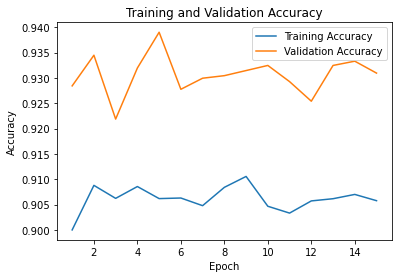

In [30]:
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

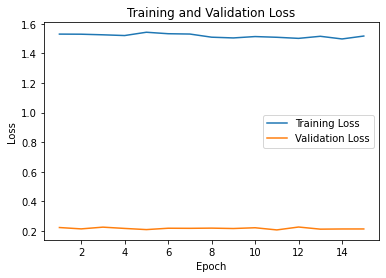

In [31]:
train_loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [32]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 2s 26ms/step - loss: 1.1398 - accuracy: 0.8338 - precision: 0.8502 - recall: 0.8172 - f1_score: 0.8334


[1.1397671699523926,
 0.8338384032249451,
 0.8502364754676819,
 0.8171716928482056,
 0.8333761692047119]